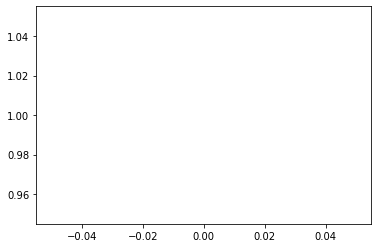

In [2]:

import os
import gc
import time
import torch
import numpy as np
import torch.nn as nn
%matplotlib inline
#%matplotlib notebook

import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch.optim import lr_scheduler
from torch.utils.data import ConcatDataset

from dataset import MyDataset,SynthText, TotalText, Ctw1500Text, Icdar15Text, LsvtTextJson,\
    Mlt2017Text, TD500Text, ArtTextJson, Mlt2019Text, Ctw1500Text_New, TotalText_New, ArtText
from network.loss import TextLoss
from network.textnet import TextNet
from util.augmentation import Augmentation
from cfglib.config import config as cfg, update_config, print_config
from util.misc import AverageMeter
from util.misc import mkdirs, to_device
from cfglib.option import BaseOptions
from util.visualize import visualize_network_output
from torch.utils.tensorboard import SummaryWriter
from util.shedule import FixLR

from test_config_400_1 import configuration as test_config
from train_config_400_1 import configuration as train_config

import matplotlib.pyplot as plt
from demo import visualize_detection
import cv2

#torch.cuda.empty_cache()

plt.plot([1])
plt.show()

Loading from model/MyDataset/TextBPN_resnet50_270.pth
output_dict['fy_preds'].shape=torch.Size([1, 4, 640, 640])
py_pred.shape=torch.Size([35, 30, 2])
py_pred.shape=torch.Size([35, 30, 2])
py_pred.shape=torch.Size([35, 30, 2])
py_pred.shape=torch.Size([35, 30, 2])
ind.shape=torch.Size([35]) ind=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
ind.shape=torch.Size([35]) ind=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output_dict['confidences']=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
output_dict['fy_preds'].shape=torch.Size([1, 4, 640, 640])
py_pred.shape=torch.Size([36, 30, 2])
py_pred.shape=torch.Size([36, 30, 2])
py_pred.shape=torch.Size([36, 30, 2])
py_pred.shape=torch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


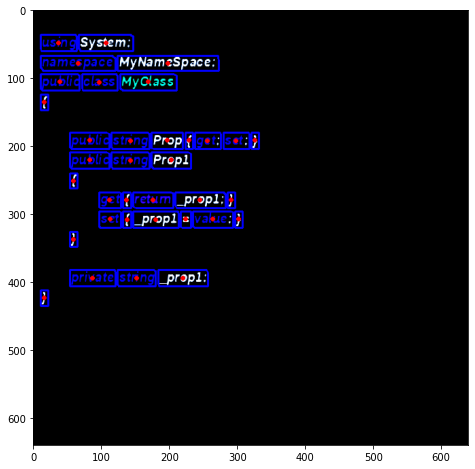

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


get_center_loss(centers_fact, centers_pred)=tensor(1203.4429)


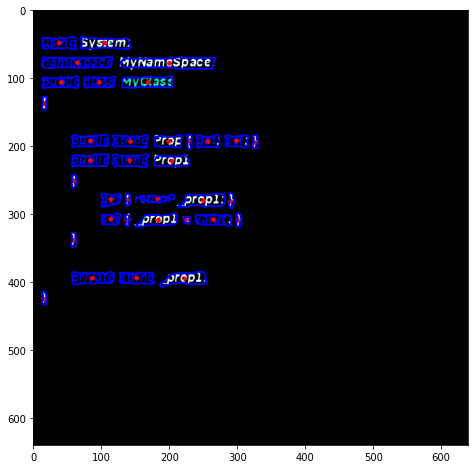

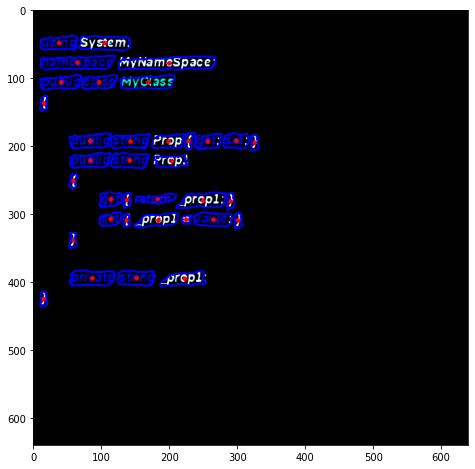

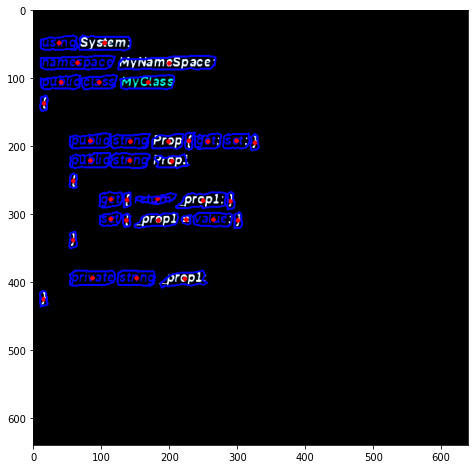

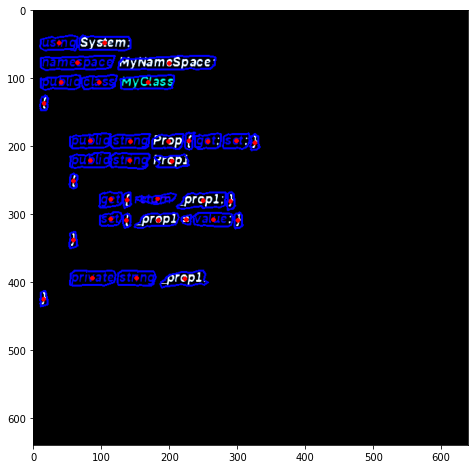

In [14]:
from cfglib.config import config
from util.my_utils import get_center_loss,get_center_counters_fact,get_center_counters_predict

# option = BaseOptions()
# args = option.initialize()
# #update_config(cfg, args)
input_size = 640
means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)
num_workers = 1
device = 'cuda'
net = 'resnet50'
is_training = False
config.device = 'cpu'

# configuration = [{
#     'fonts':['dataset/MyGenerator/font.ttf']
#     , 'texts':['''dataset/MyGenerator''']
#     , 'size_images':[(300,300)]
#     , 'position_texts':[(40,200)]
#     , 'font_sizes':[12]
#     , 'text_colors':['#ff0000']
# }]


trainset = MyDataset(
            test_config[2:3],
            is_training=True,
            transform=Augmentation(size=input_size, mean=means, std=stds)
        )

train_loader = data.DataLoader(trainset
                                   , batch_size=1
                                   , shuffle=True
                                   #, num_workers=num_workers
                                   , pin_memory=True
                                   , generator=torch.Generator(device=config.device)
                                   )
#from network.layers.model_block import FPN
#fpt = FPN(net, is_training=True)
#from network.layers.resnet import ResNet
#backbone = ResNet(name=net, pretrain=is_training)
def _parse_data(inputs):
    input_dict = {}
    #inputs = list(map(lambda x: to_device(x), inputs))
    input_dict['img'] = to_device(inputs[0])
    # input_dict['train_mask'] = inputs[1]
    # input_dict['tr_mask'] = inputs[2]
    # input_dict['distance_field'] = inputs[3]
    # input_dict['direction_field'] = inputs[4]
    # input_dict['weight_matrix'] = inputs[5]
    # input_dict['gt_points'] = inputs[6]
    # input_dict['proposal_points'] = inputs[7]
    # input_dict['ignore_tags'] = inputs[8]

    return input_dict
model = TextNet(backbone=net, is_training=False)
#model_path = 'model/MLT2019/TextBPN_resnet50_300.pth'
#model_path = 'model/MyDataset/TextBPN_resnet50_550.pth'
model_path = 'model/MyDataset/TextBPN_resnet50_270.pth'
model.load_model(model_path)
model = model.to(device)
model.eval()
#print(model)
config.device = device
input_item = None
min_loss = 1000000
output_result = None
for idx,inputs in enumerate(train_loader):
    if idx > 3:
        break
    with torch.no_grad():
        input_dict = _parse_data(inputs)
            
        output_dict = model(input_dict)
        
        print(f"{output_dict['fy_preds'].shape=}")
        for py_pred in output_dict['py_preds']:
            print(f"{py_pred.shape=}")
        for ind in output_dict['inds']:
            print(f"{ind.shape=} {ind=}")
        print(f"{output_dict['confidences']=}")
        
        centers_fact = get_center_counters_fact(inputs)    
        centers_pred = get_center_counters_predict(output_dict)
        #print(f'{centers_pred=}')

        loss = get_center_loss(centers_fact, centers_pred)
        if loss is not None and  loss < min_loss:
            min_loss = loss
            input_item = inputs
            output_result = output_dict
        
        #torch.cuda.empty_cache()
        #print(f'{output_dict=}')
        #break


#_,axs = plt.subplots(1,5,figsize=(8*5,8))
if input_item is not None:
    img_show = input_item[0][0].permute(1,2,0).cpu().numpy()
    im_show0 = img_show.copy()
    centers_fact = get_center_counters_fact(input_item)
    #print(f'{centers_fact=}')

    for cx,cy in centers_fact:
        cx,cy = int(cx.item()),int(cy.item())
        cv2.circle(im_show0, (cx, cy), 2, (255, 0, 00), 2)

    contours = input_item[6][0].cpu().numpy()
    cv2.drawContours(im_show0, contours.astype(np.int32), -1, (0, 0, 255), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(im_show0)
    plt.show()

if output_result is not None:
    centers_pred = get_center_counters_predict(output_result)
    #print(f'{centers_pred=}')

    print(f'{get_center_loss(centers_fact, centers_pred)=}')

    show_boundary, heat_map = visualize_detection(img_show, output_result, meta=None)
    for idx,py in enumerate(output_result['py_preds']):
        #if idx != 2: continue
        im_show0 = img_show.copy()
        for cx,cy in centers_pred:
            cx,cy = int(cx.item()),int(cy.item())
            cv2.circle(im_show0, (cx, cy), 2, (255, 0, 00), 2)
        contours = py.data.cpu().numpy()
        cv2.drawContours(im_show0, contours.astype(np.int32), -1, (0, 0, 255), 2)
        plt.figure(figsize=(8,8))
        plt.imshow(im_show0)

    plt.show()

In [48]:
s = [cv2.boundingRect(contour) for contour in contours]
s1 = list(sorted(s, key = lambda x: (
                                    ((x[0]+x[1])/2)*((x[2]+x[3])/2)
                                )))
s1

[(7, 31, 76, 31),
 (8, 72, 75, 23),
 (87, 30, 67, 32),
 (87, 69, 59, 25),
 (6, 108, 87, 28),
 (7, 140, 63, 32),
 (160, 31, 63, 30),
 (78, 139, 70, 33),
 (7, 218, 75, 26),
 (7, 249, 63, 32),
 (7, 285, 58, 31),
 (7, 362, 59, 26),
 (7, 327, 71, 23),
 (154, 140, 86, 33),
 (91, 327, 66, 22),
 (6, 432, 63, 28),
 (6, 396, 70, 30),
 (72, 360, 68, 26),
 (221, 249, 61, 32),
 (163, 327, 75, 24),
 (75, 430, 71, 30),
 (78, 248, 136, 34),
 (153, 429, 68, 31),
 (245, 327, 78, 24),
 (231, 430, 64, 30)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 31 76 31
залог


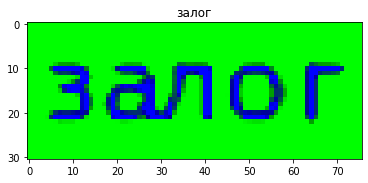

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 72 75 23
богу,


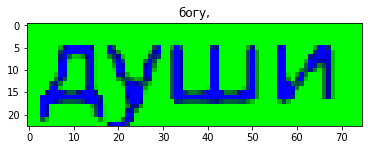

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


87 30 67 32
всех


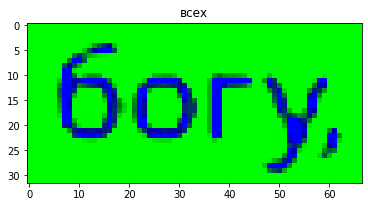

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


87 69 59 25
души


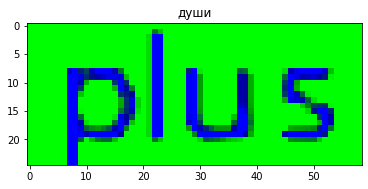

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 108 87 28
plus


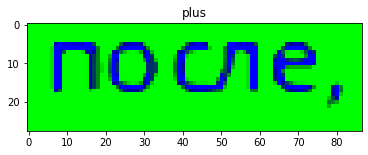

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 140 63 32
после,


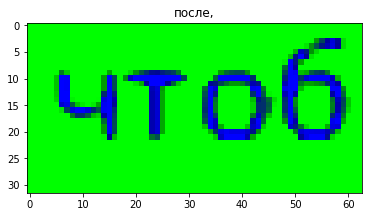

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


160 31 63 30
чтоб


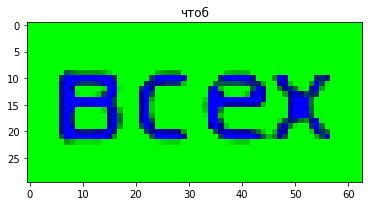

78 139 70 33
боже


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


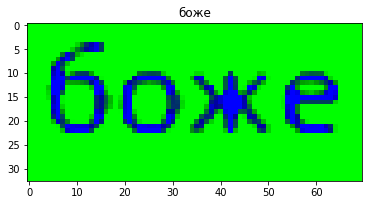

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 218 75 26
очень


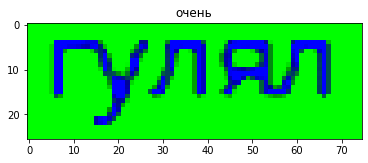

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 249 63 32
гулял


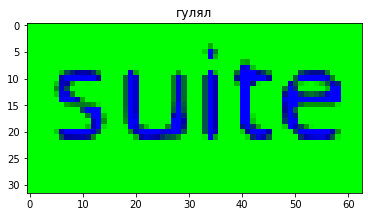

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 285 58 31
suite


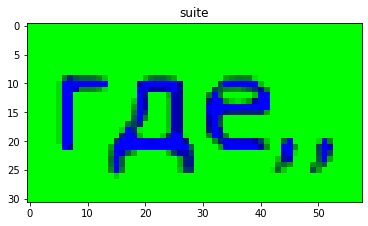

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 362 59 26
d’un,всему


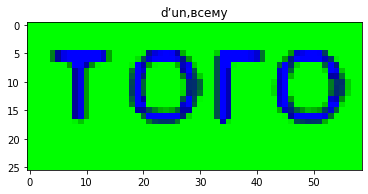

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 327 71 23
avec


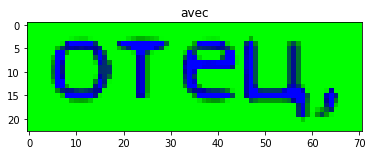

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154 140 86 33
где,,


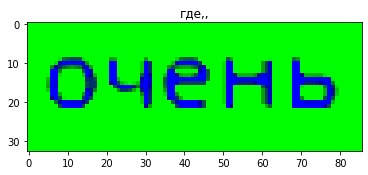

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


91 327 66 22
отец,


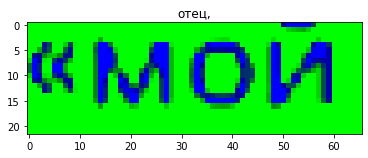

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 432 63 28
«мой


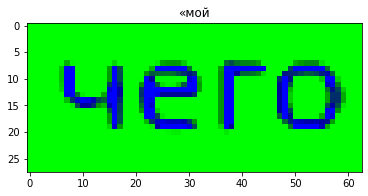

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 396 70 30
сверх


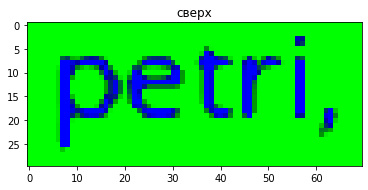

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


72 360 68 26
глава


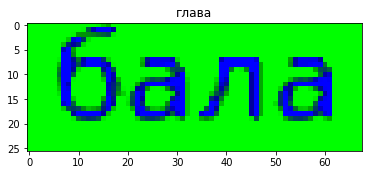

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


221 249 61 32
того


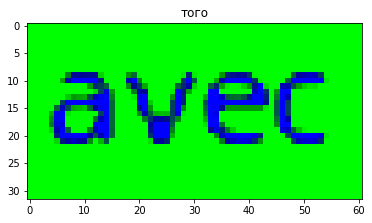

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


163 327 75 24
бала


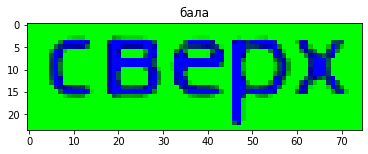

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


75 430 71 30
pеtri,


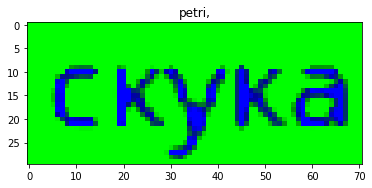

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


78 248 136 34
чего


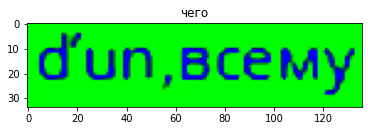

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


153 429 68 31
скука


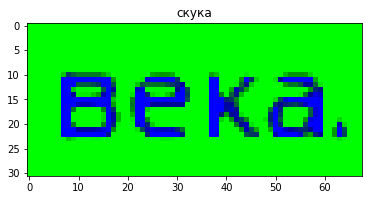

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


245 327 78 24
века.


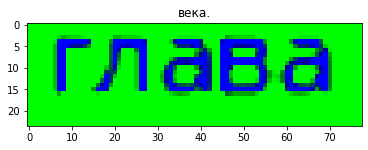

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


231 430 64 30
avait


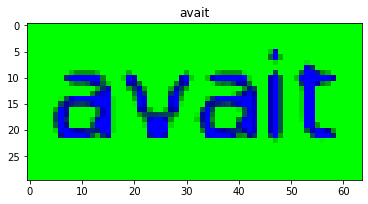

In [49]:
words = trainset.torch_text_dict.get_labels(input_item[9][0])

im_show0 = img_show.copy()
for (x, y, w, h), word in zip(s1, words):
    #x, y, w, h = cv2.boundingRect(contour)
    print(x, y, w, h)
    print(word)

    im_part = im_show0[y:y+h, x:x+w]

    #cv2.drawContours(im_show0, contours.astype(np.int32), -1, (0, 0, 255), 2)
    plt.title(word)
    plt.imshow(im_part,)
    plt.show()


In [16]:
for k in output_dict.keys():
    if torch.is_tensor(output_dict[k]):
        print(f'{k=}, {output_dict[k].shape}')
    else:
        if output_dict[k] is None:
            print(f'{k=} None')
        else:
            for item in output_dict[k]:
                if torch.is_tensor(item):
                    print(f'{k=}, {item.shape=}')



k='fy_preds', torch.Size([1, 4, 640, 640])
k='py_preds', item.shape=torch.Size([25, 30, 2])
k='py_preds', item.shape=torch.Size([25, 30, 2])
k='py_preds', item.shape=torch.Size([25, 30, 2])
k='py_preds', item.shape=torch.Size([25, 30, 2])
k='inds', torch.Size([2, 25])
